Puedes utilizar estos entornos para ejecutar el código (si lo haces así tienes que subir los datos)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# REDES RECURRENTES (intro con series temporales)

Adaptado de [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch15.html#cnn_chapter), utilizando lo aprendido en las sesiones de series temporales

Requisitos y recomendaciones:  
* Python 3.7 o superior
* Tensorflow 2.8 o superior
* Es preferible utilizar un entorno con GPU (si se quiere probar la parte LSTM y GRU mejor con Nvida, ya que Keras emplea cuRNN que es una mejora basada en CUDA para Nvidia), por ejemplo Colab de Google

In [2]:
from packaging import version
import tensorflow as tf
import sys

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Algunas preconfiguraciones para hacer más "visibles" los gráficos

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# RNNs básicas, resolviendo un problema "sencillo" de series temporales

## Redes Recurrentes

Igual que las redes convolucionales nacen de intentar capturar la información espacial que existe en las imágenes y extraer las features correspondientes, las redes recurrentes pretenden capturar la relación temporal que puede existir entre las instancias de nuestro dataset. 

Sí de nuevo tendremos unas capas "recurrentes" para extraer features y unas densas para rematar el trabajo

¿Qué es una red recurrente?

Una red neuronal recurrente es la que emplea capas con celdas (ahora se llaman celdas :-)) recurrentes. Las celdas son un tipo especial de "neurona" que además de su salida tradicional (una regresión lineal de sus entradas filtradas por una función de activación) también entrega una salida adicional denominada hidden state (estado oculto). En el principio de los tiempos el estado oculto era igual a la salida.  
  
Una capa recurrente utiliza como entrada la salida de la capa anterior y los estados ocultos que han devuelto sus neuronas/celdas en el input anterior. Es decir que si las entradas están ordenadas las capas recurrentes procesan la entrada que le toque más la anterior.  
  
* Si las entrada es una serie temporal, en cada intervalo de tiempo procesaremos ese intervalo junto con la salida del procesado del anterior.   

* Si la entrada es una frase, con cada palabra procesaremos esa palabra más la salida del procesado de la anterior. 

EINH????

Véamoslo con un gráfico para la estructura sencilla (la salida de una instancia se lleva a la entrada de la siguiente):  


<img src="./img/neurona_recurrente.jpg" alt="drawing" width="600"/>

La neurona recibe en cada instante la instancia que toca en ese momento más la salida del procesado por la neurona de la instancia anterior. La primera instancia de nuestro dataset recibe un cero (es una stateless RNN, lo veremos pero en la clase de NLP con Deep)

Si tenemos un dataset como el siguiente (instancias con dos features)
[[0,23],[1,-3],[1,56],[2,12],....]

Supongamos que nuestra neurona tiene pesos w1 = 2 , w2 = 3, w3 = -0.1  (w1,w2 para las features de entrada y w3 para la realimentación):

La neurona para t= 0 (primera instancia) tendrá como entrada:

entrada: [0,23] + [0] (No hay valor anterior) y 
salida: (Es RELU la función de activación, luego veremos que no se usan en RNN, y por qué): RELU(2 * 0 + 23 + (-2) * 0) = RELU(23) = 23

Para t=1 (la segunda instancia):

entrada: [1,-3] + [23] (la salida de la anterior)
salida: RELU(2 * 1 + 3 * (-3) + (-0.1) * 23) = RELU(2-9-2.3) = 0

Para t=2 (la tercera instancia):

entrada: [1,56] + [0]
salida: RELU(2 * 1 + 3 * 56 + (-0.1) * 0) = RELU( 2 + 168 - 0) = 170

Para t=3:

entrada: [2,12] + [170]
salida: RELU(2 * 1 + 3 * 12 + (-0.1) * 170) = RELU(2 + 36 -17) = RELU(21) = 21

....

Las salidas se van minorando si la aportación de las anteriores es positiva... 

**Se dice que este tipo de "neuronas"/"celdas" tienen un efecto memoria porque aplican modificaciones en función del "pasado"**



### Capas Recurrentes

Una capa recurrente está constituida por una o más celdas recurrentes


<img src="./img/capa_recurrente.jpg" alt="drawing" width="600"/>

La forma de la derecha es lo que se dice el unrolling de la capa, porque es como si la cada entrada m pasase por la misma capa n-m veces para cada siguiente step m (vamos que es como si la entrada-instancia 0 pasa por la capa 2 veces para la instancia 2, etc)

Esto permite a la capa aprender relaciones temporales. 

Luego veremos que existen otras "neuronas"/"celdas" que su "hidden_state" no es único o que no es exactamente la salida de las celda. Servirá para aumentar el efecto memoria y aprender relacioines más complejas. 

### Entrenamiento de una red recurrente (con series)

Las redes recurrentes (en general) no se entrenan por batches de instancias "separadas", sino que se entrenan por batches de secuencias de instancias (el target se asigna por secuencia, otro tema es que ahora el target puede ser una única etiqueta o tener tantas etiquetas como elementos la secuencia, o tantas etiquetas como periodos que queramos predecir)

Ejemplos:

1. Serie temporal (cada instancia representa un día, y tiene dos features, (prevision_temperatura, prevision_velocidad del viento), y el target es (mañana_buen_dia para hacer surf = 0, mañana_mal_dia =1))

x_train: [[12,120],[11,100],[16,70],[14,90],[6,85],....]
y_train: [0,0,1,0,1,0,0,1,....]

En un entrenamiento de en **una capa densa** s se podrían dar batches (por ejemplo de 2) como:
* Batch1: [([12,20],0),([16,70],1)]
* Batch2: [([6,85],1),([11,100],0)]
...

En un entrenamiento de **una RNN**, tenemos que decir el tamaño del batch  (2) y el de la secuencia (por ejemplo 2) (y preparar los datos para que se pueda hacer así) y además decir como será el target:

RNN_1:  
* ejemplo1: Batch1: [[12,120],[11,100]],[[14,90],[6,85]] targets: [0,1] (Solo doy el target del último día de la secuencia porque solo quiero predecir el día siguiente de la secuencia...)  
* ejemplo2: Batch1: [[12,120],[11,100]],[[14,90],[6,85]] targets: [[0,1,0],[1,0,1]] (Ahora quiero predecir 3 días siguientes)
* ejemplo3: Batch1: [[12,120],[11,100]],[[14,90],[6,85]] targets: [[0,0],[0,1]] (Doy el target para cada elemento de la secuencia)  

Ojo: haremos que la red diferencie entre el ejemplo 2 y 3 configurando las capas final y las recurrentes de la forma adecuada

....

### Utilización de las redes recurrentes

Según las configuremos las capas recurrentes, la red pueden dar salida de diferentes formas, recibiendo nombres diferentes

**Seq2Vec:**  

Entra una secuencia y la red nos devuelve un vector (ojo que puede tener más de un valor)  
Es el caso de nuestra predicción de surf con recurrentes a un día (entra una secuencia de dos días y nos devuelve un único valor: 0 buen día, 1 mal día)

<img src="./img/seq2vec.jpg" alt="drawing" width="350"/>

Podría ser el caso también de introducir una frase  y esperar que nos diga cual es la siguiente palabra en esa frase (sí, la frase hay que pasarla a números, no nos devolverá una palabra sino un número que nosotros convertiremos a palabra usando un vocabulario)



**Seq2Seq:**  

Ahora no quiero sólo que me prediga un día sino varios, le introduzco una secuencia de entrada y quiero que me de una secuencia de salida (para cada step quiero una salida, si introduzco secuencias de 20 intervalos quiero una salida de 20 intervalos, aunque esta salida sea multidimiensional)

<img src="./img/seq2seq.jpg" alt="drawing" width="350"/>  


**Vec2Seq:**

Le doy el mismo vector de características en n periodos de tiempo y quiero que me de una secuencia de salida. por ejmplo una imagen y quiero que la describa con palabras (eh, este os ha dejado flipados, eh?)  

<img src="./img/vec2sec.jpg" alt="drawing" width="350"/> 

  
**Encoder-Decoder**

Es un tipo particular de seq2seq, en el que entra una secuencia pero que hasta que no la he recibido al completo no devuelve otra secuencia. Primero se hace un seq2veq en el encoder y luego un veq2seq en el decoder (para traducciones, cambios de estilo, prompt models)

<img src="./img/encoder_decoder.jpg" alt="drawing" width="350"/> 

### A lo práctico, primero con series temporales como hasta ahora

Vamos a utilizar los datos diarios de utilización de autobuses y tren de la ciudad de Chicago. Están extraídos de su portal de datos públicos, y te recomiendo que te des una vuelta por él. Chicago es una de las ciudades más Smart del mundo y llevan recogiendo datos de diversos temas desde hace mucho tiempo... [Chicago's Data Portal](https://data.cityofchicago.org/)


In [4]:
import pandas as pd

DATA_PATH = "./data/CTA_-_Ridership_-_Daily_Boarding_Totals.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
# Hacemos un poco de limpieza
df = df.drop("total", axis=1)  # No se necesita el total (viajes en bus+tren)
df = df.drop_duplicates()  # Quitamos duplicados, hay varios

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Como hacemos con las series temporales, primero un pequeño vistazo que vamos a limitar hasta 2019, por razones obvias... ¿no?

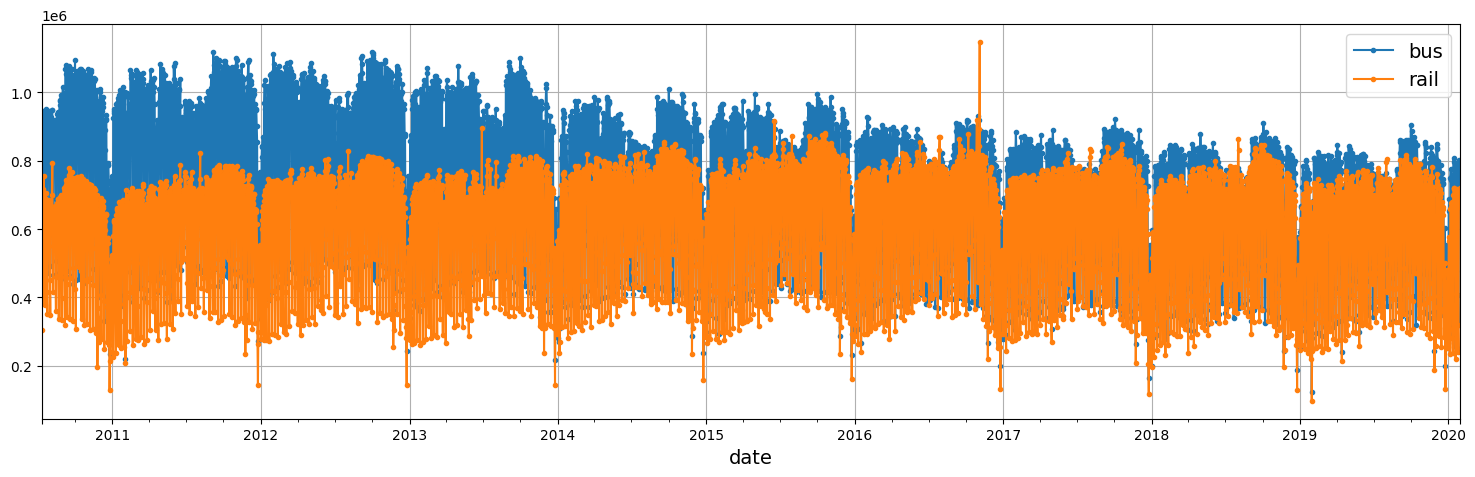

In [6]:
df["2010-07-11":"2020-01-31"].plot(grid = True, marker = ".", figsize = (15,5) ) # Al hacer la fecha el indice podemos utilizarla facilmente como índice
plt.tight_layout()

Instalar las librerías necesarias en Colab o Kaggle

In [7]:
import sys
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels
    %pip install -q -U pmdarima

A "ojo", se ven trend y seasonality, hagamos una descomposición,... hmmm

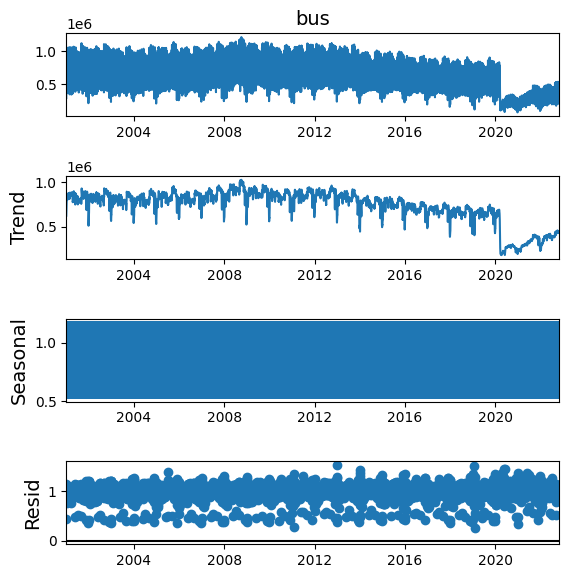

In [9]:
import seaborn as sns
import numpy as np
import pmdarima
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['bus'], model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(df['bus'], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul.plot();

Son muchos datos y ya hemos visto por lo menos la estacionalidad anual, veamos entonces un periodo más corto (tres meses de 2019) y el dataset anualizado

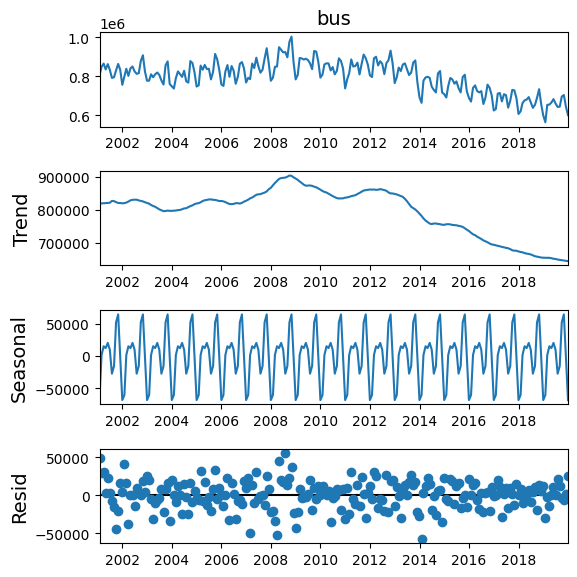

In [22]:
df_mensualizada = df.resample("M").mean(numeric_only= True)
result_add = seasonal_decompose(df_mensualizada["bus"][:"2019-12-31"], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

c:\Users\glezr\Deep_Learning\BootCamp\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


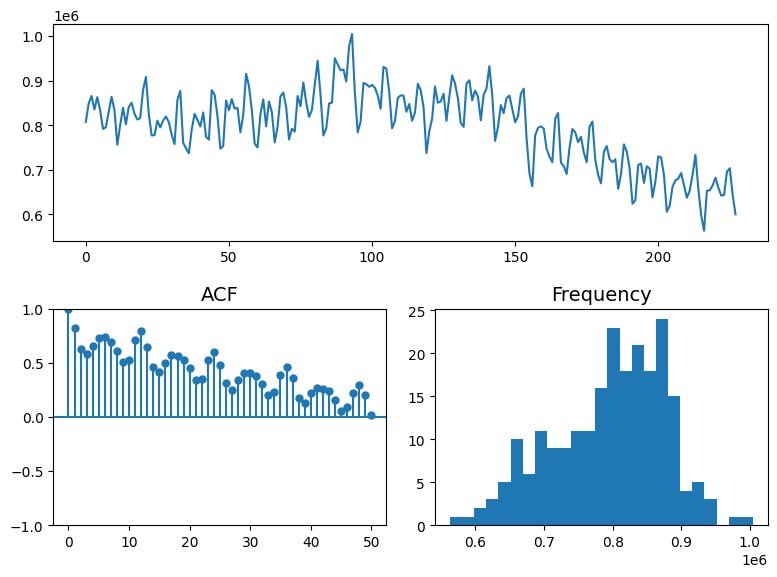

In [24]:
pmdarima.tsdisplay(df_mensualizada["bus"][:"2019-12-31"])

In [29]:
df_semanal = df["2018-01-01":"2019-12-31"].resample("W").mean(numeric_only= True)

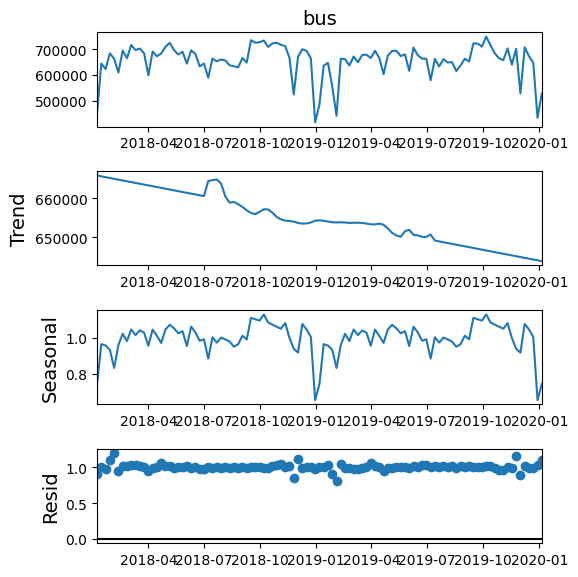

In [31]:
result_add = seasonal_decompose(df_semanal["bus"], model = 'multiplicative', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

Parece que existe esa componente semanal, pero para verla mejor podemos pintar la serie original y su desplazada siete días hacia delante y ver si hay parecido


In [35]:
df.head(10)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356
2001-01-07,U,375831,169825
2001-01-08,W,985221,590706
2001-01-09,W,978377,599905


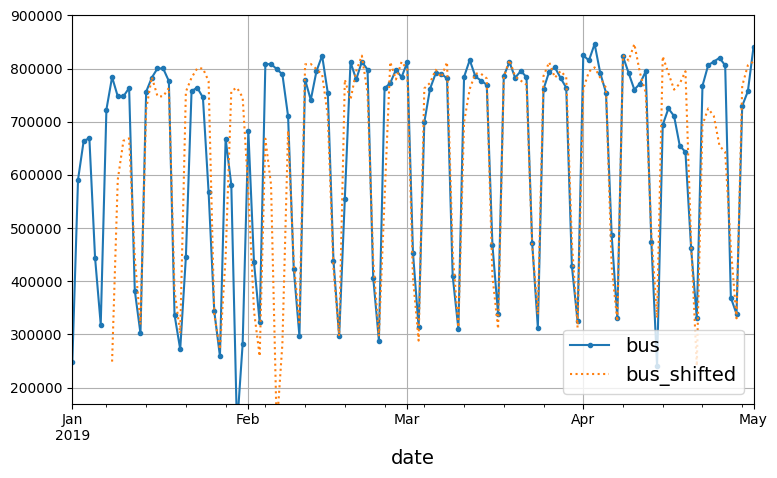

In [51]:
df_season_week = df["2019-01-01":"2019-05-01"][["bus"]]
df_shifted = df_season_week.shift(7)
df_shifted.rename(columns={"bus": "bus_shifted"}, inplace= True)
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 5))
df_season_week.plot(ax = axs, legend=True, marker=".")  # original time series
df_shifted.plot(ax = axs, grid=True, legend=True, linestyle=":")  # lagge
axs.set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.tight_layout()
plt.show()

En el libro, Geron muestra una predicción "naive", utilizar el valor de la semana anterior que da un buen resultado y no es mala práctica para este tipo de series

Nosotros vamos a establecer un baseline a partir de un autoarima, trabajando solo sobre un corto periodo de tiempo para que los entrenamientos posteriores de la red deep no sean excesivos (incluso utilizando GPU)

In [67]:
inicio, fin = "2019-01-01", "2019-05-31"
train = df[inicio:fin]["rail"]
test_2w = df["2019-06-01":"2019-06-14"]["rail"]
test_1d = df["2019-06-01":"2019-06-01"]["rail"]

In [64]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")

In [68]:
print(rail_series)

date
2019-01-01    245852
2019-01-02    573542
2019-01-03    627781
2019-01-04    628514
2019-01-05    348257
               ...  
2019-05-27    256757
2019-05-28    694292
2019-05-29    717681
2019-05-30    735508
2019-05-31    738322
Freq: D, Name: rail, Length: 151, dtype: int64


In [69]:
print(train)

date
2019-01-01    245852
2019-01-02    573542
2019-01-03    627781
2019-01-04    628514
2019-01-05    348257
               ...  
2019-05-27    256757
2019-05-28    694292
2019-05-29    717681
2019-05-30    735508
2019-05-31    738322
Name: rail, Length: 151, dtype: int64


In [77]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 7,
                    trace=False,
                    stepwise=True)

print(model.aic())

predictions_2w = model.predict(14)
predictions_1d = model.predict(1)

print()
print()
print("REPORT")
print("Predictions 2 weeks ahead")
print("mean_absolute_error:", mean_absolute_error(test_2w, predictions_2w))
print()
print("-"*20)
print("Predictions 1 day")
print("mean_absolute_error:", mean_absolute_error(test_1d, predictions_1d))
print()
mae_base = mean_absolute_error(test_2w, predictions_2w)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=4009.594, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4109.158, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4020.549, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4056.192, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4107.197, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=4035.978, Time=0.16 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=4013.961, Time=0.16 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=4011.255, Time=0.29 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=4011.392, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=4027.616, Time=0.30 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=4011.258, Time=0.19 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4010.384, Time=0.10 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=4

In [75]:
predictions_2w

2019-06-01    448859.259889
2019-06-02    359097.553137
2019-06-03    558497.649971
2019-06-04    721360.762815
2019-06-05    743770.638701
2019-06-06    755678.155960
2019-06-07    739932.467570
2019-06-08    492582.294303
2019-06-09    417779.615836
2019-06-10    606417.964139
2019-06-11    761954.498427
2019-06-12    785522.703108
2019-06-13    799014.450420
2019-06-14    786228.634352
Freq: D, dtype: float64

mean_absolute_error: 52099.24073694122


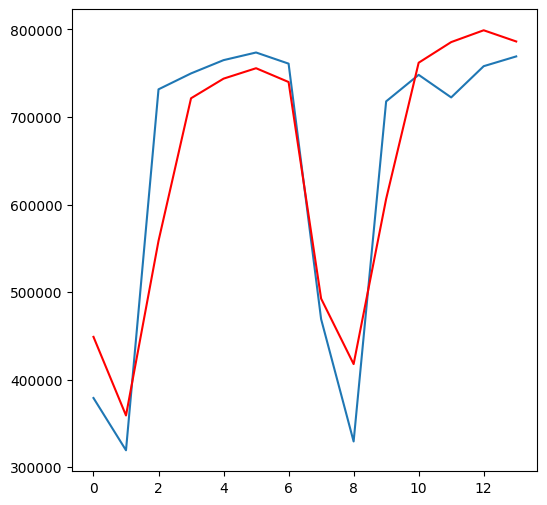

In [76]:
print("mean_absolute_error:", mean_absolute_error(test_2w, predictions_2w))
plt.plot(test_2w.values)
plt.plot(predictions_2w.values,color='red');

In [93]:
origin, start_date, end_date = "2019-01-01", "2019-05-31", "2019-06-13"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
dia = 0
print("Dia\tReal\tPrediccion")
print("-"*20)
for today in time_period.shift(-1): # Vamos a entrenar el modelo cada día, para obtener mejor, en teoría, rendimiento que prediciendo a 14 días desde el último
    model = auto_arima(rail_series[origin:today],
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 7,
                    trace=False,
                    stationary= False,
                    stepwise=True,
                    error_action="ignore")
    
    # note that we retrain the model every day!
    y_pred = model.predict(1).values[0]
    print("%s\t%.2f\t%.2f" %(today,rail_series[time_period[dia]], y_pred))
    y_preds.append(y_pred)
    dia += 1

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7
mape = mean_absolute_percentage_error(rail_series[time_period].values, y_preds.values)

Dia	Real	Prediccion
--------------------
2019-05-30 00:00:00	738322.00	593566.69
2019-05-31 00:00:00	379044.00	448859.26
2019-06-01 00:00:00	319334.00	377336.88
2019-06-02 00:00:00	731571.00	388883.72
2019-06-03 00:00:00	749759.00	738934.85
2019-06-04 00:00:00	764911.00	675517.17
2019-06-05 00:00:00	773638.00	791157.34
2019-06-06 00:00:00	760907.00	743893.52
2019-06-07 00:00:00	469189.00	507821.68
2019-06-08 00:00:00	329388.00	364103.54
2019-06-09 00:00:00	717811.00	489225.73
2019-06-10 00:00:00	748133.00	860184.93
2019-06-11 00:00:00	722333.00	746883.29
2019-06-12 00:00:00	758006.00	785973.93


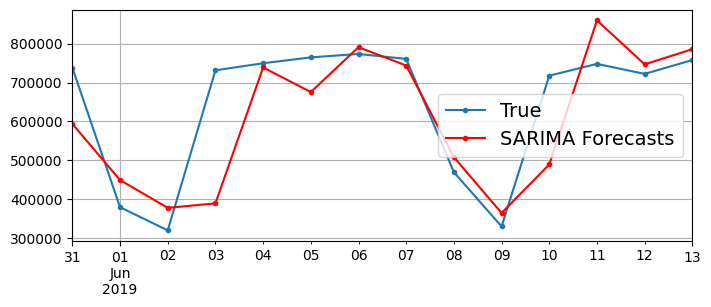

In [95]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

In [97]:
print(mae,mape)

86893.94022499849 0.1381044162962164


## Y AHORA CON REDES NEURONALES

Las redes recurrentes además de su complejidad para "visualizarlas" mentalmente y la propia de tener que configurarlas como cualquier otra capa de DL, añaden la farragosa tarea de preparar los dataset de entrada...   

Recuerda que ahora espera batches de secuencias con multiples posibilidades en los targets... 
  
Empecemos construyendo el dataset de entrada para una predicción al día siguiente después de 56 días (es decir 8 semanas)

In [113]:
# Al igual que teniamos el "generador" de imágenes sintéticas, tensorflow tiene un generador de datasets para series temporales que nos viene perfecto (https://keras.io/api/preprocessing/timeseries/)
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

Con vistas a lo que haremos después, es interesante conocer el metodo window() de los "datasets" de tensorflow (un tipo particular de dataframe de tensores de TF)

In [116]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1): #Creo un dataset con los números del 0 al 5 y creo ventanas de 4 elementos, desplazandome 1 después (sí como el stride, si pongo shitf mayor de 1, va cogiendo ventanas desplazadas más de un elemento :-)
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


El código siguiente se comporta similar al timeseries_dataset_from_array pero pudiendo controlarlo nosotros, lo usaremos al final

In [27]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [28]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [29]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Hacemos tres datasets: entrenamiento, validación y test y aplicamos "normalización" casera, aunque al ser una serie univariante (sólo vamos a usar por ahora una única característica) no debería afectarlem

In [118]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

De los dataframes pasamos a los datasets preparados para entrenar las capas recurrentes usando el comentado timeseries_dataset_from_array

In [31]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [32]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0098 - mae: 0.1118 - val_loss: 0.0071 - val_mae: 0.0966
Epoch 2/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0070 - mae: 0.0883 - val_loss: 0.0052 - val_mae: 0.0768
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0796 - val_loss: 0.0050 - val_mae: 0.0741
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0055 - mae: 0.0761 - val_loss: 0.0049 - val_mae: 0.0732
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0054 - mae: 0.0749 - val_loss: 0.0043 - val_mae: 0.0666
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0724 - val_loss: 0.0041 - val_mae: 0.0638
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0047 - mae: 0.0696 - val_loss: 0.0040 - val_mae: 0.0615
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0051 - m

In [33]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0379


37866.38006567955

## Using a Simple RNN

Ahora vamos a emplear una única capa con una única celda o neurona recurrente sencilla (el hidden_stat(t) = output(t-1) y hidden_state(0) = 0)
Es interesante darse cuenta de que la función de activación no es una relu es una tanh... ¿Por qué?

https://keras.io/api/layers/recurrent_layers/simple_rnn/

In [34]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [35]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [36]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 11ms/step - loss: 0.0219 - mae: 0.1637 - val_loss: 0.0195 - val_mae: 0.1394
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0170 - mae: 0.1553 - val_loss: 0.0179 - val_mae: 0.1482
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0166 - mae: 0.1555 - val_loss: 0.0176 - val_mae: 0.1501
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0164 - mae: 0.1558 - val_loss: 0.0173 - val_mae: 0.1534
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0163 - mae: 0.1572 - val_loss: 0.0172 - val_mae: 0.1479
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0162 - mae: 0.1555 - val_loss: 0.0170 - val_mae: 0.1496
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0162 - mae: 0.1556 - val_loss: 0.0168 - val_mae: 0.1552
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0161 - 

102786.95076704025

Y ahora ya vamos a emplear una capa con 32 neurona y luego una capa densa que nos de la regresión, sin función de activación

In [37]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [38]:

fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0489 - mae: 0.2061 - val_loss: 0.0060 - val_mae: 0.0854
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0060 - mae: 0.0813 - val_loss: 0.0052 - val_mae: 0.0825
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0042 - mae: 0.0647 - val_loss: 0.0041 - val_mae: 0.0656
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0041 - mae: 0.0636 - val_loss: 0.0042 - val_mae: 0.0714
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0039 - mae: 0.0595 - val_loss: 0.0023 - val_mae: 0.0387
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0033 - mae: 0.0542 - val_loss: 0.0026 - val_mae: 0.0423
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0030 -

29014.97296988964

## Deep RNNs

Hora de aplicar unas cuantas capas de recurrentes a ver si captan más patrones temporales y mejora nuestro regresor, 

In [39]:
# Importante: ahora tengo que pasarle todos los valores de salida de cada elemento de la secuencia a las capas siguientes menos a la última, por eso return_sequence = True

tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [40]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 2s 32ms/step - loss: 0.0393 - mae: 0.2109 - val_loss: 0.0085 - val_mae: 0.1110
Epoch 2/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0068 - mae: 0.0858 - val_loss: 0.0032 - val_mae: 0.0629
Epoch 3/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0750 - val_loss: 0.0035 - val_mae: 0.0638
Epoch 4/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0048 - mae: 0.0678 - val_loss: 0.0021 - val_mae: 0.0429
Epoch 5/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0043 - mae: 0.0606 - val_loss: 0.0020 - val_mae: 0.0408
Epoch 6/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0042 - mae: 0.0591 - val_loss: 0.0027 - val_mae: 0.0502
Epoch 7/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0045 - mae: 0.0635 - val_loss: 0.0025 - val_mae: 0.0469
Epoch 8/500
33/33 [==============================] - 1s 24ms/step - loss: 0.

31211.024150252342

## Series multivariantes

Pues como tenemos más series temporales que covarian con la de "rail", vamos a usarlas para hacer un modelo multivariante

In [41]:
df_mulvar = df[["bus", "rail"]] / 1e6  # Usaremos los datos de uso de autobus y tren (metro y tren elevado)
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # Pero también podemos utilizar el tipo de día que es "mañana"
df_mulvar = pd.get_dummies(df_mulvar)  # siempre como número, así que le hacemos un one-hot-encoding

In [42]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [44]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [45]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0386 - mae: 0.1872 - val_loss: 0.0011 - val_mae: 0.0346
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0585 - val_loss: 0.0040 - val_mae: 0.0790
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0018 - mae: 0.0435 - val_loss: 7.7056e-04 - val_mae: 0.0273
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.0407 - val_loss: 0.0010 - val_mae: 0.0362
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0386 - val_loss: 8.1681e-04 - val_mae: 0.0306
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0014 - mae: 0.0372 - val_loss: 0.0011 - val_mae: 0.0380
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0366 - val_loss: 7.9942e-04 - val_mae: 0.0289
Epoch 8/500
33/33 [==============================] - 0s 10ms/step

22062.301635742188

## Predecir varios intervalos temporales en el futuro 

Pero al igual que hicimos con el autoarima, nos gustaría predecir no sólo al día siguiente sino los x días siguientes...

Caso 1: Como hacemos con el predict(num_intervalos) del autoarima (vamos prediciendo añadiendo las predicciones de días siguientes)

In [49]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

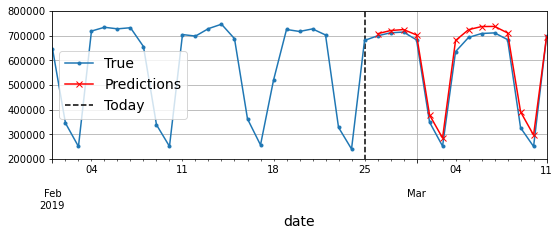

In [50]:

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Caso 2: Vamos a crear una red que entrene para predecir los 14 días siguientes de una vez  

Para ello preparamos los datos de entrada de forma que el target serán ahora los 14 días siguientes a cada instante...   

Por tanto, si nuestras secuencias tienen 56 días, ahora el target serán 56 vectores de 14 valores (ejemplo 2 del surf, pero con 56 de tamaño de secuencia y 14 de predicción)

In [120]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

NameError: name 'mulvar_train' is not defined

In [52]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [53]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.1250 - mae: 0.3791 - val_loss: 0.0287 - val_mae: 0.1935
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0191 - mae: 0.1613 - val_loss: 0.0136 - val_mae: 0.1289
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0131 - mae: 0.1303 - val_loss: 0.0102 - val_mae: 0.1113
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0108 - mae: 0.1164 - val_loss: 0.0083 - val_mae: 0.1009
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0093 - mae: 0.1068 - val_loss: 0.0071 - val_mae: 0.0931
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0083 - mae: 0.0996 - val_loss: 0.0061 - val_mae: 0.0862
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0076 - mae: 0.0941 - val_loss: 0.0055 - val_mae: 0.0811
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0072 - 

35017.29667186737

In [54]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

Caso 3 (particular del 2): Vamos a hacer un modelo seq2seq, en vez de esperar a tener los 56 primeros valores para dar la predicción de los siguientes 14 días...

... vamos a construir un modelo que a cada step ya nos esté prediciendo los 14 siguientes días y si le introduzco una secuencia de 10 días para predecir me de 10 salidas de predicción (esto permite tener errores predicción a predicción) (ojo en el día 3 haré predicciones sólo basándome en los dos días anteriores aunque mi secuencia de entrada sea de 10 días, el modelo es CAUSAL, que se dice)

La preparación es un poco más engorrosa, y se usa la función to_window() que creamos hace ya unas cuantas "celdas" de Notebook 

In [55]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Y ahora separamos en x_train y y_train:

In [56]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Lo dejo en inglés, porque es todo mérito de AG: Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [57]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [58]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [59]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [60]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0754 - mae: 0.2785 - val_loss: 0.0163 - val_mae: 0.1379
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0097 - mae: 0.1050 - val_loss: 0.0071 - val_mae: 0.0853
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0069 - mae: 0.0846 - val_loss: 0.0063 - val_mae: 0.0790
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0060 - mae: 0.0773 - val_loss: 0.0056 - val_mae: 0.0729
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0722 - val_loss: 0.0049 - val_mae: 0.0662
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0052 - mae: 0.0690 - val_loss: 0.0051 - val_mae: 0.0683
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0663 - val_loss: 0.0046 - val_mae: 0.0626
Epoch 8/500
33/33 [==============================] - 0s 11ms/step - loss: 0.

45928.88057231903

In [61]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

In [62]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

MAE for +1: 25,519
MAE for +2: 26,274
MAE for +3: 27,054
MAE for +4: 29,324
MAE for +5: 28,992
MAE for +6: 31,739
MAE for +7: 32,847
MAE for +8: 33,282
MAE for +9: 33,072
MAE for +10: 29,752
MAE for +11: 37,468
MAE for +12: 35,125
MAE for +13: 34,614
MAE for +14: 34,322


# LSTMs

Las celdas LSTM (Long-Short Term Memory), buscan aumentar la capacidad de "memoria". Para ello ahora además de un hidden_state, devuelven un c_state en lo que vendría a ser hidden_state -> memoria a corto plazo, c_state -> memoria a largo plazo.

Para nosotros se quedan en caja negra que funcionan mejor que las neuronas recurrentes tradicionales :-), aún así os dejo aquí el esquema de una LSTM por si a alguien le pica el gusanillo:


<img src="./img/LSTM.webp" alt="drawing" width="600"/>


https://www.turing.com/kb/comprehensive-guide-to-lstm-rnn

Por otro lado, las celdas LSTM se pueden incorpar como tal o usando una capa especial LSTM.

In [69]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [70]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 29ms/step - loss: 0.0535 - mae: 0.2517 - val_loss: 0.0187 - val_mae: 0.1716
Epoch 2/5
33/33 [==============================] - 1s 16ms/step - loss: 0.0176 - mae: 0.1598 - val_loss: 0.0176 - val_mae: 0.1473
Epoch 3/5
33/33 [==============================] - 1s 16ms/step - loss: 0.0160 - mae: 0.1528 - val_loss: 0.0168 - val_mae: 0.1433
Epoch 4/5
33/33 [==============================] - 1s 16ms/step - loss: 0.0152 - mae: 0.1485 - val_loss: 0.0161 - val_mae: 0.1388
Epoch 5/5
3/3 [==============================] - 0s 14ms/step - loss: 0.0154 - mae: 0.1352


135186.25497817993

# GRUs

Las celdas GRU (Gated Recurrent Unit) son una "simplificación" de las LSTM, que intenta conseguir lo mismo, aumentar la memoria, pero simplificando algunos elementos. De hecho esta celda sólo tiene un hidden_state.

Os dejo el esquema y la referencia:

<img src="./img/gru_diagram.png" alt="drawing" width="350"/>

http://primo.ai/index.php?title=Gated_Recurrent_Unit_%28GRU%29

Las LSTM y las GRU son mucho más efectivas que las simples RNN y son las que se usan hoy en día. Como las LSTM tienen su propia capa aunque puedes utilizarlas como celdas en una SimpleRNN y el funcionamiento es similar.


In [71]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [72]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 29ms/step - loss: 0.0516 - mae: 0.2489 - val_loss: 0.0165 - val_mae: 0.1529
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0145 - mae: 0.1386 - val_loss: 0.0139 - val_mae: 0.1260
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0118 - mae: 0.1249 - val_loss: 0.0121 - val_mae: 0.1170
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0106 - mae: 0.1166 - val_loss: 0.0111 - val_mae: 0.1109
Epoch 5/5
3/3 [==============================] - 0s 14ms/step - loss: 0.0104 - mae: 0.1071


107093.29694509506

## Convlucionales y Recurrente juntas

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [73]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [74]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 30ms/step - loss: 0.0482 - mae: 0.2420 - val_loss: 0.0214 - val_mae: 0.1616
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0165 - mae: 0.1532 - val_loss: 0.0171 - val_mae: 0.1423
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0144 - mae: 0.1447 - val_loss: 0.0157 - val_mae: 0.1342
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 0.0130 - mae: 0.1361 - val_loss: 0.0141 - val_mae: 0.1254
Epoch 5/5
1/1 [==============================] - 0s 88ms/step - loss: 0.0124 - mae: 0.1159


115850.42625665665